In [1]:
import pandas as pd
import numpy as np
import scipy.io
from scipy import stats

from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, Bidirectional, Concatenate, Permute, Dot, Input, LSTM, Multiply
from keras.layers import RepeatVector, Dense, Activation, Lambda
from keras.activations import softmax
from keras.models import load_model, Model
from keras.optimizers import Adam
from keras import backend as K

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

Using TensorFlow backend.


# Configuration

In [2]:
#div, baseline and label involve the use of memory
#divide the feature value
div = 2.9
#choose the feature value more than baseline
baseline = 3
#number of predicted label
label = 5
#path to dataset
pathX = 'X/X_seed10000_cv2.0.mat'
pathY = 'KEEPK_Y/KEEPK_Y_seed10000_cv2.0_kr1.0_keep5.mat'

savedModel = 'modelx.h5'

# Load Data

In [3]:
x_train = scipy.io.loadmat(pathX)['X_train']
x_test = scipy.io.loadmat(pathX)['X_test']

y_train = scipy.io.loadmat(pathY)['Y_train']
y_test = scipy.io.loadmat(pathY)['Y_test']

In [4]:
print('x train =',(len(x_train),len(x_train[0])))
print('x test =',(len(x_test),len(x_test[0])))

print('y train =',(len(y_train),len(y_train[0])))
print('y test =',(len(y_test),len(y_test[0])))

x train = (428, 17737)
x test = (214, 17737)
y train = (428, 194)
y test = (214, 194)


# Prepare Data

Prepare Labels

In [5]:
#convert nan to zero
where_are_NaNs = np.isnan(y_train)
y_train[where_are_NaNs] = 0

where_are_NaNs = np.isnan(y_test)
y_test[where_are_NaNs] = 0

In [6]:
y_train_mx_ind = []
y_test_mx_ind = []
for line in y_train:
    y_train_mx_ind.append(line.argsort()[-4:][::-1])

for line in y_test:
    y_test_mx_ind.append(line.argsort()[-4:][::-1])

y_ind_set = set()
for line in y_train_mx_ind:
    for word in line:
        y_ind_set.add(word)
for line in y_test_mx_ind:
    for word in line:
        y_ind_set.add(word)
        
y_ind = list(y_ind_set)
len(y_ind),len(y_train_mx_ind),len(y_test_mx_ind)

(194, 428, 214)

In [7]:
y_ind.sort()
ind_to_y = dict(zip([i for i in range(1,len(y_ind)+1)],y_ind))
ind_to_y[0] = -1
y_mx = len(y_ind)
y_to_ind = {v: k for k, v in ind_to_y.items()}
y_mx

194

In [8]:
y_train_normalize = []
y_test_normalize = []

for line in y_train_mx_ind:
    y_train_normalize.append([y_ind[word] for word in line])

for line in y_test_mx_ind:
    y_test_normalize.append([y_ind[word] for word in line])

np.array(y_train_normalize).shape, np.array(y_test_normalize).shape

((428, 4), (214, 4))

In [9]:
one_hot_y_train = to_categorical(y_train_normalize, y_mx+1)
one_hot_y_test = to_categorical(y_test_normalize, y_mx+1)
one_hot_y_train.shape, one_hot_y_test.shape

((428, 4, 195), (214, 4, 195))

Prepare Feature

In [10]:
x_mx = int(round(max(max(x_train.flatten()),max(x_test.flatten()))))
x_mn = int(round(min(min(x_train.flatten()),min(x_test.flatten()))))
x_mx,x_mn

(14, 2)

In [11]:
x_train_ind = []
x_test_ind = []
for line in x_train:
    x_train_ind.append([int(ind*x_mx//div + round(line[ind])//div) for ind in range(len(line)) if line[ind]//div > baseline])

for line in x_test:
    x_test_ind.append([int(ind*x_mx//div + round(line[ind])//div) for ind in range(len(line)) if line[ind]//div > baseline])

In [12]:
print('x_train =', np.array(x_train_ind).shape)
print('x_test =', np.array(x_test_ind).shape)

x_train = (428,)
x_test = (214,)


In [13]:
x_ind_set = set()
for line in x_train_ind:
    for word in line:
        x_ind_set.add(word)

for line in x_test_ind:
    for word in line:
        x_ind_set.add(word)
        
x_ind_list = list(x_ind_set)
x_ind_list.sort()

In [14]:
ind_to_x = dict(zip([i for i in range(1,len(x_ind_list)+1)], x_ind_list))
ind_to_x[0] = -1
x_mx = len(x_ind_list)
x_to_ind = {v: k for k, v in ind_to_x.items()}
x_mx

1125

In [15]:
x_train_normalize = []
x_test_normalize = []

for line in x_train_ind:
    x_train_normalize.append([x_to_ind[word] for word in line])

for line in x_test_ind:
    x_test_normalize.append([x_to_ind[word] for word in line])

np.array(x_train_normalize).shape, np.array(x_test_normalize).shape

((428,), (214,))

In [16]:
# one-hot is too sparse matrix and insufficient memory
x_train_normalize = pad_sequences(x_train_normalize, maxlen = x_mx)
x_test_normalize = pad_sequences(x_test_normalize, maxlen = x_mx)

one_hot_x_train = to_categorical(x_train_normalize,x_mx+1)
one_hot_x_test = to_categorical(x_test_normalize,x_mx+1)

In [17]:
print('x_train =',one_hot_x_train.shape)
print('x_test =',one_hot_x_test.shape)

x_train = (428, 1125, 1126)
x_test = (214, 1125, 1126)


In [18]:
emptyFeature = one_hot_x_train[:,:,0].sum()
allFeature = x_train.shape[0]*x_train.shape[1]
print('Feature used in the model',round((1-emptyFeature/allFeature)*100,2),'%')
print('Feature used in the training set',round((x_mx/x_train.shape[1])*100,2),'%')
print('All used feature',round((x_mx/x_train.shape[1])*(1-emptyFeature/allFeature)*100,2),'%')

Feature used in the model 94.18 %
Feature used in the training set 6.34 %
All used feature 5.97 %


# Prepare Model

In [19]:
n_h = 64 #hidden dimensions for encoder 
n_s = 64 #hidden dimensions for decoder
decoder_LSTM_cell = LSTM(n_s, return_state = True) #decoder_LSTM_cell
output_layer = Dense(y_mx+1, activation="softmax") #softmax output layer
#att_layer = Dense(max_len, activation=None) #None output layer

In [20]:
def softMaxAxis1(x):
    return softmax(x,axis=1)

In [21]:
Tx = len(one_hot_x_train[0])
Ty = len(one_hot_y_train[0])
vocab_size = x_mx+1
m = len(one_hot_x_train)

In [22]:
#These are global variables (shared layers)
repeator = RepeatVector(Tx)
concatenator = Concatenate(axis=-1)
#Attention function###
fattn_1 = Dense(100, activation = "tanh")
fattn_2 = Dense(1, activation = "relu")
###
activator = Activation(softMaxAxis1, name='attention_scores') 
dotor = Dot(axes = 1)
## you are allowed to use code in the demo as your template.

In [23]:
def one_step_attention(a, s_prev):
    # Repeat the decoder hidden state to concat with encoder hidden states
    #key, con = tf.split(a,2,1)
    key = Lambda(lambda x: x[:,:,:64])(a)
    con = Lambda(lambda x: x[:,:,64:])(a)
    s_prev = repeator(s_prev)
    concat = concatenator([s_prev,key])
    # attention function
    e = fattn_1(concat)
    energies =fattn_2(e)
    # calculate attention_scores (softmax)
    attention_scores = activator(energies)
    #calculate a context vector
    context = dotor([attention_scores,con])
    return context,attention_scores

In [24]:
def model(Tx, Ty, n_h, n_s, vocab_size):
    """
    Arguments:
    Tx -- length of the input sequence
    Ty -- length of the output sequence
    n_h -- hidden state size of the Bi-LSTM
    n_s -- hidden state size of the post-attention LSTM
    vocab_size -- size of the input vocab
    output_vocab_size -- size of the output vocab

    Returns:
    model -- Keras model instance
    """
    
    # Define the input of your model
    X = Input(shape=(Tx, vocab_size))
    #X = Embedding(vocab_size+1, 64)(X)

    # Define hidden state and cell state for decoder_LSTM_Cell
    s0 = Input(shape=(n_s,), name='s0')
    c0 = Input(shape=(n_s,), name='c0')
    s = s0
    c = c0
    
    # Initialize empty list of outputs
    outputs = list()
    #Encoder Bi-LSTM
    h = Bidirectional(LSTM(n_h, return_sequences=True),input_shape=(m, Tx, n_h*2))(X)

    #Iterate for Ty steps (Decoding)
    for t in range(Ty):
    
        #Perform one step of the attention mechanism to calculate the context vector at timestep t
        context,attention = one_step_attention(h, s)
       
        # Feed the context vector to the decoder LSTM cell
        s, _, c = decoder_LSTM_cell(context,initial_state=[s,c])
        
        # Pass the decoder hidden output to the output layer (softmax)
        out = output_layer(s)

        # Append an output list with the current output
        outputs.append(out)

    #Create model instance
    model = Model(inputs=[X,s0,c0],outputs=outputs)
    
    return model

In [25]:
model = model(Tx, Ty, n_h, n_s, vocab_size)

Instructions for updating:
Colocations handled automatically by placer.


Model Summary

In [26]:
opt = Adam(lr= 0.01, decay = 0.01)
model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1125, 1126)   0                                            
__________________________________________________________________________________________________
s0 (InputLayer)                 (None, 64)           0                                            
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 1125, 128)    609792      input_1[0][0]                    
__________________________________________________________________________________________________
repeat_vector_1 (RepeatVector)  (None, 1125, 64)     0           s0[0][0]                         
                                                                 lstm_1[0][0]                     
          

In [27]:
s0 = np.zeros((m, n_s))
c0 = np.zeros((m, n_s))
Y = one_hot_y_train
outputs = list(Y.swapaxes(0,1))

Fit The Model

In [28]:
X = one_hot_x_train
model.fit([X, s0, c0], outputs, epochs=250, batch_size=50)

Epoch 1/5
428/428 [==============================] - 46s 107ms/step - loss: 21.0966 - dense_1_loss: 5.2659 - dense_1_acc: 0.0047 - dense_1_acc_1: 0.0093 - dense_1_acc_2: 0.0140 - dense_1_acc_3: 0.0304
Epoch 2/5
428/428 [==============================] - 37s 87ms/step - loss: 20.9808 - dense_1_loss: 5.1754 - dense_1_acc: 0.0023 - dense_1_acc_1: 0.0047 - dense_1_acc_2: 0.0187 - dense_1_acc_3: 0.0514
Epoch 3/5
428/428 [==============================] - 60s 141ms/step - loss: 20.8788 - dense_1_loss: 5.1123 - dense_1_acc: 0.0023 - dense_1_acc_1: 0.0047 - dense_1_acc_2: 0.0187 - dense_1_acc_3: 0.0514
Epoch 4/5
428/428 [==============================] - 62s 144ms/step - loss: 20.8131 - dense_1_loss: 5.0777 - dense_1_acc: 0.0023 - dense_1_acc_1: 0.0047 - dense_1_acc_2: 0.0187 - dense_1_acc_3: 0.0514
Epoch 5/5
428/428 [==============================] - 60s 139ms/step - loss: 20.7763 - dense_1_loss: 5.0669 - dense_1_acc: 0.0023 - dense_1_acc_1: 0.0047 - dense_1_acc_2: 0.0187 - dense_1_acc_3: 0.0

Save Model

In [29]:
model.save(savedModel) 

c:\users\kok\anaconda3\envs\py36\lib\site-packages\keras\engine\network.py:877: UserWarning: Layer lstm_1 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 's0:0' shape=(?, 64) dtype=float32>, <tf.Tensor 'c0:0' shape=(?, 64) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '
c:\users\kok\anaconda3\envs\py36\lib\site-packages\keras\engine\network.py:877: UserWarning: Layer lstm_1 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_1/TensorArrayReadV3:0' shape=(?, 64) dtype=float32>, <tf.Tensor 'lstm_1/while/Exit_4:0' shape=(?, 64) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '
c:\users\kok\anaconda3\envs\py36\lib\site-packages\keras\engine\network.py:877: UserWarning: Layer lstm_1 was passed non-serializable keyword arguments

Start Prediction

In [37]:
model.load_weights(savedModel)

In [38]:
prediction = model.predict([one_hot_x_test[:label], s0, c0])

In [39]:
prediction = np.swapaxes(prediction,0,1)
y_pred = prediction
prediction = np.argmax(prediction, axis = -1)

In [40]:
def get_output_layer(model, layer_name):
    # get the symbolic outputs of each "key" layer (we gave them unique names).
    layer_dict = dict([(layer.name, layer) for layer in model.layers])
    layer = layer_dict[layer_name]
    return layer

att_layer = get_output_layer(model, "attention_scores")

In [41]:
s0 = np.zeros((len(one_hot_x_test[:label]), n_s))
c0 = np.zeros((len(one_hot_x_test[:label]), n_s))
s0.shape, c0.shape

((5, 64), (5, 64))

In [42]:
percent = []
for i in range(4):
    output_fn = K.function(model.inputs, [att_layer.get_output_at(i)])
    percent.append(output_fn([one_hot_x_test[:label], s0, c0]))
percent = np.array(percent)
percent.shape

(4, 1, 5, 1125, 1)

In [43]:
tmp = percent[0]
for i in percent[1:]:
    tmp = np.concatenate((tmp,i),axis = -1)
tmp = np.array(tmp)
tmp.shape

(1, 5, 1125, 4)

# Data virtualization

1125 4


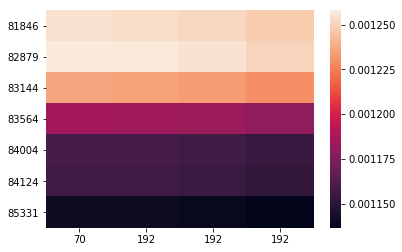

In [44]:
inp = [ind_to_x[int(i)] for i in x_test_normalize[0]]
out = [ind_to_y[int(i)] for i in prediction[0]]
print(len(inp),len(out))
df = pd.DataFrame(tmp[0][0],index = inp, columns = out)
plt.rcParams['font.family']='Loma'
ax = sns.heatmap(df[-7:])

#X -> Output (medicines)
#Y -> Input (Genes)

In [46]:
score = 0
for i in range(len(prediction)):
    for word in prediction[i]: 
        if ind_to_y[word] in y_test_mx_ind[i]: score+=1
print('Score',score / (prediction.shape[0] * prediction.shape[1]))

Score 0.0
